# Lab3 - Experimento Stern-Gerlach

Neste notebook aprenderemos um pouco mais sobre o famoso experimento de [Otto Stern](https://en.wikipedia.org/wiki/Otto_Stern) e [Walther Gerlach](https://en.wikipedia.org/wiki/Walther_Gerlach), em 1922, que, além da sua [importância histórica](https://physicstoday.scitation.org/doi/10.1063/1.1650229), ilustra bem como estados quânticos são diferentes de estados clássicos. 
<br>Mais do que simplesmente apresentar os resultados, **iremos simular**, de fato, **o experimento aqui**, pelo menos os elementos mais fundamentais, para mostrar como os resultados são diferentes entre os sistemas clássico e quântico.

Para concentrar a discussão na física, ao invés da programação, vou usar o [**QuTiP**](http://qutip.org/) (*Quantum Toobox in Python*), um framework para cálculos quânticos em Python. Isso permitirá usar ferramentas profissionais que definem e encapsulam em comandos simples toda a **álgebra que aprendemos nas aulas**, de uma forma mais direta e prática. Também é uma oportunidade de lhes apresentar mais uma ferramenta computacional bastante útil.
<br>Depois da aula você poderá explorar o notebook e a [documentação online do QuTip](http://qutip.org/tutorials.html) para aprender mais, se tiver interesse.

**Créditos**: na preparação dessa aula usei como base um dos tutoriais do QuTip, apesentado na EuroSciPy 2019 por Simon Cross, disponível [neste link](https://nbviewer.jupyter.org/github/qutip/qutip-notebooks/blob/master/examples/stern-gerlach-tutorial.ipynb).


# O experimento de Stern-Gerlach (1922)

### Aparato experimental

<img src="figuras/stern-gerlach-setup.png">


Fonte: http://hyperphysics.phy-astr.gsu.edu/hbase/spin.html 

<hr>
Veja também:
    
* https://plato.stanford.edu/entries/physics-experiment/app5.html.
* https://en.wikipedia.org/wiki/Stern%E2%80%93Gerlach_experiment#History
    
para mais detalhes e informações sobre a história desse importante experimento.

### Carregando as bibliotecas necessárias no Python...

In [1]:
%matplotlib inline
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import qutip
from qutip import Bloch, ket

In [2]:
# About QuTip  -- visit hhtp://qutip.org
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Original developers: R. J. Johansson & P. D. Nation.
Current admin team: Alexander Pitchford, Paul D. Nation, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, and Eric Giguère.
Project Manager: Franco Nori.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.4.1
Numpy Version:      1.18.1
Scipy Version:      1.4.1
Cython Version:     0.29.17
Matplotlib Version: 3.1.3
Python Version:     3.7.4
Number of CPUs:     2
BLAS Info:          INTEL MKL
OPENMP Installed:   False
INTEL MKL Ext:      True
Platform Info:      Windows (AMD64)
Installation path:  C:\Users\SergioMuniz\Anaconda3\lib\site-packages\qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


# Esfera de Bloch
### representação do vetor de estado $|\psi\rangle$ no espaço SU(2): _spinors_ & _q-bits_

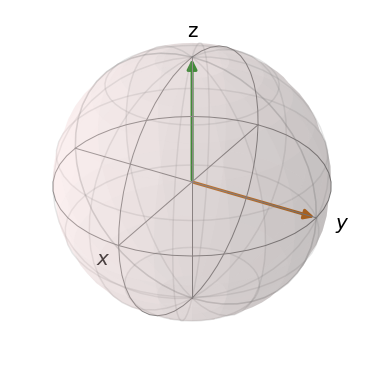

In [3]:
z = np.array([0, 0, 1])
mu = np.array([0, 1, 0])

bloch = Bloch()
bloch.zlabel=("z", "")
bloch.add_vectors([z, mu])
bloch.show()

### exemplo de evolução temporal de vetores de Bloch

<img src="figuras/Bloch-vector-evolution.png">

# Simulando Stern-Gerlach no Python!

In [4]:
# Definições gerais comuns

Direction = namedtuple("Direction", ["theta", "phi"])


def random_direction():
    """ Generate a random direction. """
    # See http://mathworld.wolfram.com/SpherePointPicking.html
    r = 0
    while r == 0:
        x, y, z = np.random.normal(0, 1, 3)
        r = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arctan2(y, x)
    theta = np.arccos(z / r)
    return Direction(theta=theta, phi=phi)


def plot_classical_results(atoms, spins):
    fig = plt.figure(figsize=(18.0, 8.0))
    fig.suptitle("Stern-Gerlach Experiment: Classical Outcome", fontsize="xx-large")

    ax1 = plt.subplot(1, 2, 1, projection='3d')
    ax2 = plt.subplot(1, 2, 2)

    b = Bloch(fig=fig, axes=ax1)
    b.vector_width = 1
    b.vector_color = ["#ff{:x}0ff".format(i, i) for i in range(10)]
    b.zlabel = ["$z$", ""]
    b.add_vectors(atoms)
    b.render(fig=fig, axes=ax1)

    ax2.hist(spins)
    ax2.set_xlabel("Z-component of spin")
    ax2.set_ylabel("# of atoms")

    
def plot_quantum_results(atoms, spins):
    fig = plt.figure(figsize=(18.0, 8.0))
    fig.suptitle("Stern-Gerlach Experiment: Quantum Outcome", fontsize="xx-large")

    ax1 = plt.subplot(1, 2, 1, projection='3d')
    ax2 = plt.subplot(1, 2, 2)

    b = Bloch(fig=fig, axes=ax1)
    b.vector_width = 1
    b.vector_color = ["#{:x}0{:x}0ff".format(i, i) for i in range(10)]
    b.add_states(atoms)
    b.render(fig=fig, axes=ax1)

    ax2.hist(spins)
    ax2.set_xlabel("Z-component of spin")
    ax2.set_ylabel("# of atoms")

## Simulando o caso clássico

In [5]:
# Simulation of expected results in the classical case

classical_up = np.array([0, 0, 1])

def classical_state(d):
    """ Prepare a spin state given a direction. """
    x = np.sin(d.theta) * np.cos(d.phi) 
    y = np.sin(d.theta) * np.sin(d.phi)
    z = np.cos(d.theta)
    return np.array([x, y, z])


def classical_spin(c):
    """ Measure the z-component of the spin. """
    return classical_up.dot(c)


def classical_stern_gerlach(n):
    """ Simulate the Stern-Gerlach experiment """
    directions = [random_direction() for _ in range(n)]
    atoms = [classical_state(d) for d in directions]
    spins = [classical_spin(c) for c in atoms]
    return atoms, spins


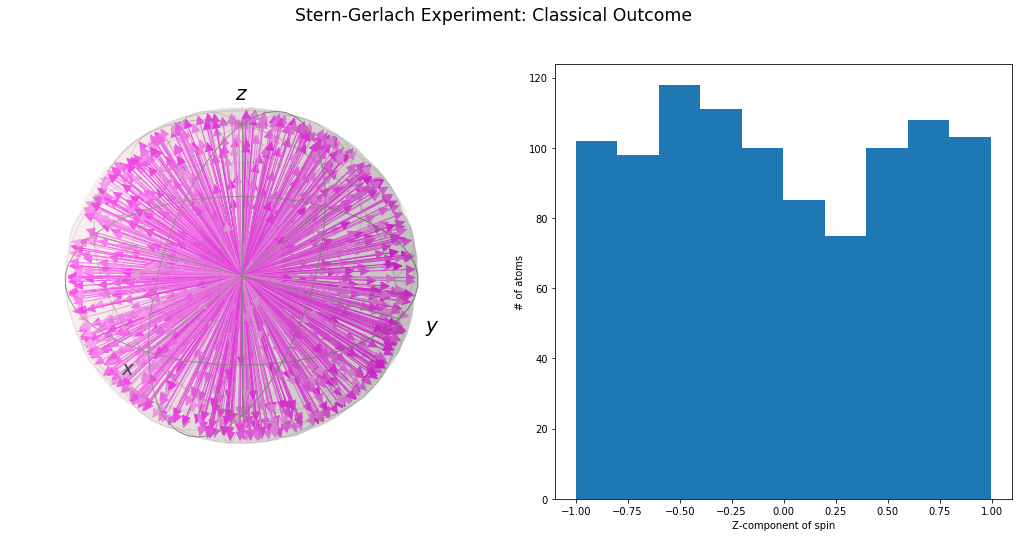

In [6]:
atoms, spins = classical_stern_gerlach(1000)
plot_classical_results(atoms, spins)

## Os resultados experimentais (reais) observados

<img src="figuras/stern-gerlach-resultados.png">

## Simulando o caso Quântico

In [7]:
# Simulation of expected results in the quantum case
# usando a biblioteca qutip
up = ket('0')
down = ket('1')


def quantum_state(d):
    """ Prepare a spin state given a direction. """
    return np.cos(d.theta / 2) * up + np.exp(1j * d.phi) * np.sin(d.theta / 2) * down


def quantum_spin(q):
    """ Measurement the z-component of the spin. """
    a_up = (up.dag() * q).tr()
    prob_up = np.abs(a_up) ** 2
    return 1 if np.random.uniform(0, 1) <= prob_up else -1


def quantum_stern_gerlach(n):
    """ Simulate the Stern-Gerlach experiment """
    directions = [random_direction() for _ in range(n)]
    atoms = [quantum_state(d) for d in directions]
    spins = [quantum_spin(q) for q in atoms]
    return atoms, spins


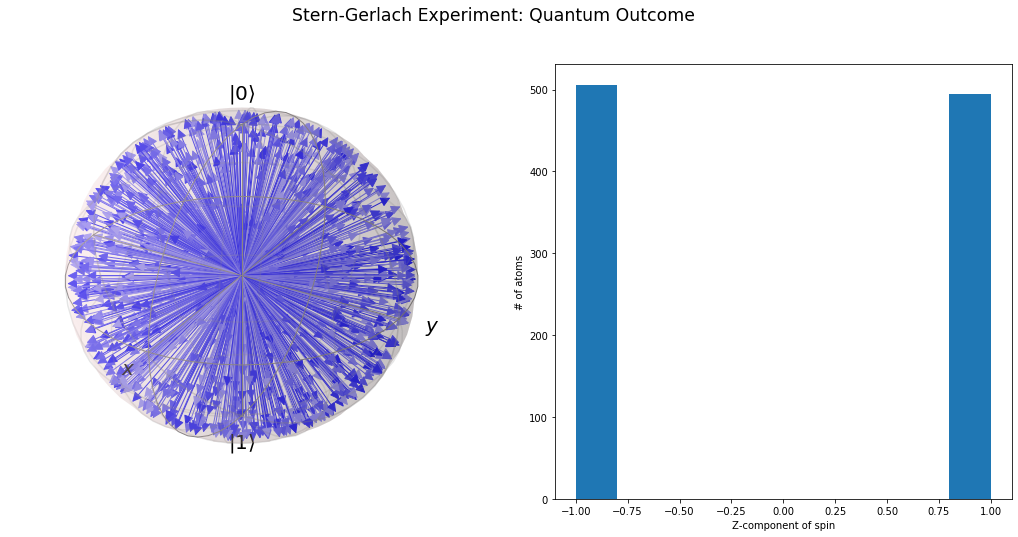

In [8]:
atoms, spins = quantum_stern_gerlach(1000)
plot_quantum_results(atoms, spins)

# Leitura complementar

1. QuTiP documentation [ https://qutip.org/ ]

2. History of the Stern-Gerlach experiment
   [ https://plato.stanford.edu/entries/physics-experiment/app5.html ]

3. Quantum Computing for the Determined by Michael Nielsen
   [ http://michaelnielsen.org/blog/quantum-computing-for-the-determined/ ]
   
4. Picking a random point on a sphere
   [ http://mathworld.wolfram.com/SpherePointPicking.html ]